In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, BatchNormalization, Activation, Dropout
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tqdm import tqdm
from glob import glob
import os
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

Using TensorFlow backend.


In [2]:
path = "../data/plant-seedlings"
batch_size = 28
epochs = 40
target_size = (200, 200)

In [3]:
# Data import
train_datagen = ImageDataGenerator(rotation_range=25,
                                   rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    path + '/train',  # this is the target directory
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
    path + '/valid',  # this is the target directory
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical')

Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.


In [5]:
# Model definition
model = Sequential()
model.add(Conv2D(16, (3, 3), input_shape=train_generator.image_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(16, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(512, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(12, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 198, 198, 16)      448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 198, 198, 16)      64        
_________________________________________________________________
activation_1 (Activation)    (None, 198, 198, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 196, 196, 16)      2320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 196, 196, 16)      64        
_________________________________________________________________
activation_2 (Activation)    (None, 196, 196, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 98, 98, 16)        0         
__________

In [6]:
# Training
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.hdf5', verbose=1, save_best_only=True)

In [9]:
history = model.fit_generator(train_generator, steps_per_epoch=3839 // batch_size, epochs=3,
                validation_data=validation_generator, validation_steps=911 // batch_size, verbose=1, callbacks=[checkpointer])

Epoch 1/3
137/137 [==============================] - 76s 556ms/step - loss: 1.1462 - acc: 0.6160 - val_loss: 1.0376 - val_acc: 0.6465

Epoch 00001: val_loss improved from 1.78756 to 1.03756, saving model to saved_models/weights.best.hdf5
Epoch 2/3
137/137 [==============================] - 71s 517ms/step - loss: 1.0774 - acc: 0.6343 - val_loss: 1.2241 - val_acc: 0.5746

Epoch 00002: val_loss did not improve from 1.03756
Epoch 3/3
137/137 [==============================] - 72s 523ms/step - loss: 0.9798 - acc: 0.6525 - val_loss: 1.4142 - val_acc: 0.5488

Epoch 00003: val_loss did not improve from 1.03756


In [8]:
model.load_weights('saved_models/weights.best.hdf5')

seedlings_names = [item[11:] for item in sorted(glob(path + "/train/*"))]

#print(seedlings_names)
f = open('results.csv', 'w')
f.write('file,species\n')

13

In [9]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=target_size)
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [18]:
test_files = glob(path + "/test/*")

test = paths_to_tensor(test_files).astype('float32')/255

output = model.predict(test)
for [o, name] in zip(output, test_files):
    name = name.split("/")[-1]
    f.write(name + ',')
    seedling = seedlings_names[np.argmax(o)].split("/")[-1]
    f.write(seedling)
    f.write('\n')
f.close()

100%|██████████| 794/794 [00:03<00:00, 252.53it/s]


In [10]:
import cv2

# function to read an image 
def read_image(filepath, target_size=None, img_resize=True):
    img = cv2.imread(os.path.join(path, filepath), cv2.IMREAD_COLOR)
    if img_resize:
        img = cv2.resize(img.copy(), target_size, interpolation = cv2.INTER_AREA)
    return img

11
Sugar beet


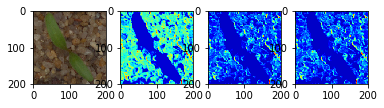

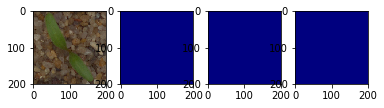

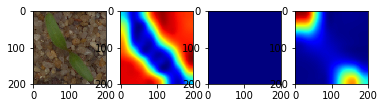

In [44]:
from vis.visualization import visualize_cam, visualize_activation
from vis.utils import utils
import matplotlib.pyplot as plt
import numpy as np
from keras import activations

"""
img = read_image("test/288564c76.png", (200, 200)).astype(np.uint8)
plt.subplot(141)
plt.imshow(img)
output = model.predict(np.expand_dims(img, axis = 0))
print(np.argmax(output))
print(seedlings_names[np.argmax(output)])
"""

input_img = image.load_img(path + "/test/288564c76.png", target_size=target_size)

img = path_to_tensor(path + "/test/288564c76.png").astype('float32')/255
output = model.predict(img)
print(np.argmax(output))
print(seedlings_names[np.argmax(output)].split("/")[-1])

layer_idx = 8

plt.subplot(141)
plt.imshow(input_img)
for j,modifier in enumerate([None, 'guided', 'relu']):
    heat_map = visualize_cam(model, layer_idx, np.argmax(output), img, backprop_modifier=modifier)
    plt.subplot(1,4,j+2)
    plt.imshow(heat_map)
    #activations = visualize_activation(model, layer_idx, np.argmax(output), img, backprop_modifier=modifier)
    #plt.subplot(1,4,j+2)
    #plt.imshow(activations)

plt.show()


plt.subplot(141)
plt.imshow(input_img)
for j,modifier in enumerate([None, 'guided', 'relu']):
    heat_map = visualize_cam(model, 20, np.argmax(output), img, backprop_modifier=modifier)
    plt.subplot(1,4,j+2)
    plt.imshow(heat_map)
    
plt.show()

"""
try:
    # Swap softmax with linear
    model.layers[-1].activation = activations.linear
    model = utils.apply_modifications(model)
except:
    pass
"""
    
plt.subplot(141)
plt.imshow(input_img)
for j,modifier in enumerate([None, 'guided', 'relu']):
    heat_map = visualize_cam(model, 38, np.argmax(output), img, backprop_modifier=modifier)
    plt.subplot(1,4,j+2)
    plt.imshow(heat_map)
    
plt.show()